In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

from tqdm.notebook import tqdm

import h5py

import data
import masks
import inference
import models

%load_ext autoreload
%autoreload 2

In [2]:
dx = 20
fs = 50.0   

nx = 11
nx_width = 1
if dx == 4:
    nx = 44
    nx_width = 4
nt = 2048

C:\Users\Alex-Master\AppData\Local\Temp\ipykernel_7656\4015930421.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample[i] = torch.roll(strain_rate, int(i*shift + np.random.randn(1)))


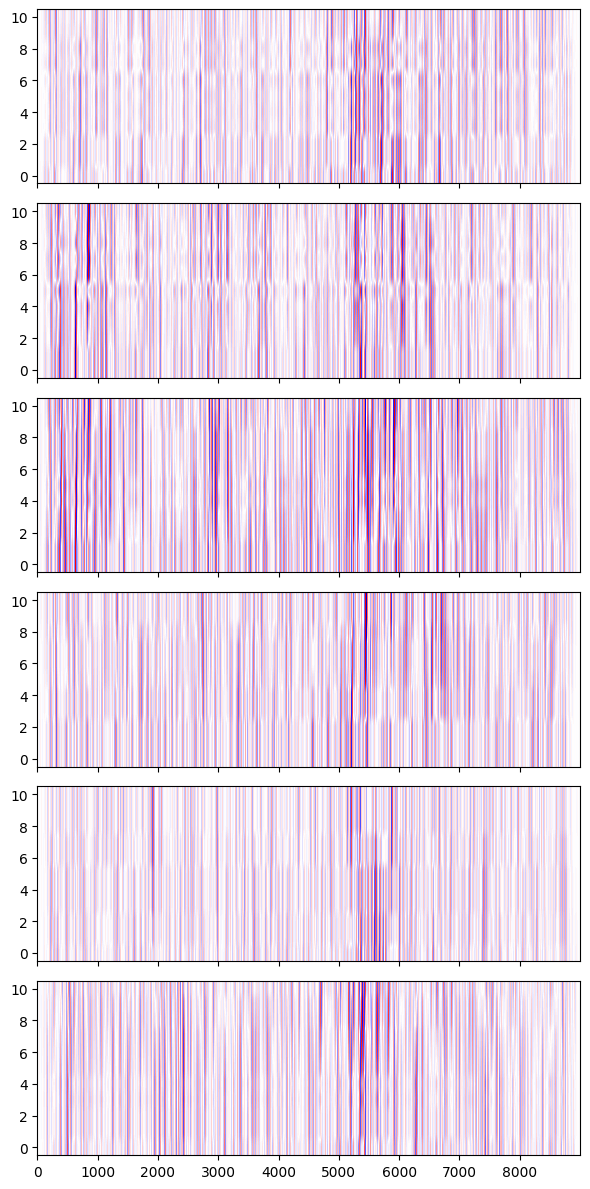

In [34]:
def generate_synthetic_das(strain_rate, gauge, fs, slowness, nx=512):

    # shift
    # slowness: 0.0001 s/m = 0.1 s/km   -  0.005 s/m = 5 s/km
    # speed: 10,000 m/s = 10 km/s    -  200 m/s = 0.2 km/s
    shift = gauge * fs * slowness # L f / v

    sample = torch.zeros((nx, len(strain_rate)))
    for i in range(nx):
        sample[i] = torch.roll(strain_rate, int(i*shift + np.random.randn(1)))
    
    return sample
def gerate_spezific_das(strain_rate,  nx=11, nt=2048, eq_slowness=0,
                 gauge=4, fs=50.0, station=None, start=None):
    if eq_slowness == 0:
        eq_slowness = 1/(gauge*fs)
    if station is not None:
        sample = strain_rate[station]
    else:
        sample = strain_rate
    if start is not None:
        sample = sample[start:start+nt]
    sample = generate_synthetic_das(sample, gauge, fs, eq_slowness, nx)
    return sample

test_path = "../../data/DAS/SIS-rotated_test_50Hz.npy"

#test_paths = sorted([test_path + f for f in os.listdir(test_path)])

indices = [6250,6750,6,5250,7250,5500]
eq_test = torch.from_numpy(np.load("../../data/DAS/SIS-rotated_test_50Hz.npy"))
test_data = []
test_data.append(gerate_spezific_das(eq_test[0]))
test_data.append(gerate_spezific_das(eq_test[1]))
test_data.append(gerate_spezific_das(eq_test[2]))
test_data.append(gerate_spezific_das(eq_test[3]))
test_data.append(gerate_spezific_das(eq_test[4]))
test_data.append(gerate_spezific_das(eq_test[5]))
#test_data = np.stack(test_data)
"""
for i, (p, idx) in enumerate(zip(test_paths, indices)):
    with h5py.File(p, 'r') as hf:
        DAS_sample = hf['DAS'][81:,idx-1024:idx+1024]
        if dx == 20:
            DAS_sample = DAS_sample[::5]
        test_data.append(DAS_sample)
"""
#test_data = np.stack(test_data)[[2,3,5,0,1,4]]

gutter = 100
test_data = np.pad(test_data, ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
test_data = data.bandpass(test_data, low=1.0, high=10.0, fs=50, gutter=gutter)
test_scale = test_data.std(axis=-1, keepdims=True)
test_data /= test_scale

test_data = torch.from_numpy(test_data.copy())
test_scale = torch.from_numpy(test_scale.copy())

fig, axs = plt.subplots(6, 1, sharex=True, sharey=True, figsize=(6,12))
for i in range(6):
    axs[i].imshow(test_data[i].numpy(), origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
plt.tight_layout()
plt.show()

# Synthetic

In [3]:
def step(model, x, loss_fn, hist, optimizer=None):
    sample, eq, noise, scale, amp = x
    sample = sample.float().to(device)
    
    loss, out, target_mask, center_mask = loss_fn(model, sample)
    
    if optimizer is not None:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    hist['loss'].append(loss.item())
    

def train(model, dloader, loss_fn, optimizer, nx, nt, nx_width, n_epochs=50, testdata=None, name=""):
    
    pbar0 = tqdm(range(n_epochs), position=0)
    for epoch in pbar0:
        pbar1 = tqdm(dloader['train'], position=1)
        train_hist = {'loss': []}
        model.train()
        for x in pbar1:
            step(model, x, loss_fn, train_hist, optimizer)
            pbar1.set_description('[train] loss: {:.6f}'.format(train_hist['loss'][-1]))
        
        with torch.no_grad():
            model.eval()
            val_hist = {'loss': []}

            for x in dloader['test']:
                step(model, x, loss_fn, val_hist)
        
            pbar0.set_description('[val] loss: {:.6f}'.format(np.mean(val_hist['loss'])))

            if (epoch + 1) % 10 == 0:
                if name != "":
                    torch.save(model.state_dict(), './ckpt/'+name+'_{:03d}.pt'.format(epoch+1))
                if (epoch + 1) % 50 == 0:
                    if testdata is not None:
                        fig, axs = plt.subplots(6, 2, sharex=True, figsize=(8,12))
                        for i, tdata in enumerate(testdata):
                            if dx == 4:
                                out = inference.xreconstruct(model, tdata, nx, nt, nx_width, batch_size=128, ende=True)
                            else:
                                out = inference.channelwise_reconstruct(model, tdata, nx, nt, batch_size=128)
                            out = out.detach().cpu()
                            axs[i,0].imshow(tdata.numpy(), origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
                            axs[i,1].imshow(out.numpy(), origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
                        plt.tight_layout()
                        plt.show()

In [7]:
#eq_train = torch.from_numpy(np.load('./data/preprocessed/SIS-rotated_train_50Hz.npy'))
eq_train = torch.from_numpy(np.load("../../data/DAS/SIS-rotated_train_50Hz.npy"))
eq_train /= eq_train.std(dim=-1, keepdim=True)
#eq_test = torch.from_numpy(np.load('./data/preprocessed/SIS-rotated_test_50Hz.npy'))
eq_test = torch.from_numpy(np.load("../../data/DAS/SIS-rotated_test_50Hz.npy"))
eq_test /= eq_test.std(dim=-1, keepdim=True)

samples_per_epoch = 10_000

trainset = data.SyntheticNoiseDAS(eq_train, nx=nx, nt=nt, dx=dx, size=samples_per_epoch)
testset = data.SyntheticNoiseDAS(eq_test, nx=nx, nt=nt, dx=dx, size=samples_per_epoch//10)

batch_size = 32
dloader = {'train': DataLoader(trainset, batch_size=batch_size, shuffle=True), 
           'test': DataLoader(testset, batch_size=batch_size, shuffle=False)}

In [35]:
model = models.N2SUNet(1, 1, 4).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def loss_fn(model, x):
    mask = masks.channelwise_mask(x, nx_width)

    out = model(x * mask)
    loss = torch.mean(torch.mean((1-mask) * (out - x)**2, dim=-1))
    return loss, out, mask, mask

name = "N2S-synthetic{}".format(dx) + "-{:d}x{:d}-{:d}x{:d}".format(nx, nt, nx_width, 2048)
train(model, dloader, loss_fn, optimizer, nx=nx, nt=nt, nx_width=nx_width, 
      n_epochs=200, testdata=test_data, name=name)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Finetuning

In [ ]:
def step(model, x, loss_fn, hist, optimizer=None):
    sample = x
    sample = sample.float().to(device)
    
    loss, out, target_mask, center_mask = loss_fn(model, sample)
    
    if optimizer is not None:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    hist['loss'].append(loss.item())
    

def train(model, dloader, loss_fn, optimizer, nx, nt, nx_width, n_epochs=50, testdata=None, name=""):
    
    pbar0 = tqdm(range(n_epochs), position=0)
    for epoch in pbar0:
        pbar1 = tqdm(dloader['train'], position=1)
        train_hist = {'loss': []}
        model.train()
        for x in pbar1:
            step(model, x, loss_fn, train_hist, optimizer)
            pbar1.set_description('[train] loss: {:.6f}'.format(train_hist['loss'][-1]))
        
        with torch.no_grad():
            model.eval()
            val_hist = {'loss': []}

            for x in dloader['test']:
                step(model, x, loss_fn, val_hist)
        
            pbar0.set_description('[val] loss: {:.6f}'.format(np.mean(val_hist['loss'])))

            if (epoch + 1) % 10 == 0:
                if name != "":
                    torch.save(model.state_dict(), './ckpt/'+name+'_{:03d}.pt'.format(epoch+1))
                if (epoch + 1) % 50 == 0:
                    if testdata is not None:
                        fig, axs = plt.subplots(6, 2, sharex=True, figsize=(8,12))
                        for i, tdata in enumerate(testdata):
                            if dx == 4:
                                out = inference.xreconstruct(model, tdata, nx, nt, nx_width, batch_size=128, ende=True)
                            else:
                                out = inference.channelwise_reconstruct(model, tdata, nx, nt, batch_size=128)
                            out = out.detach().cpu()
                            axs[i,0].imshow(tdata.numpy(), origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
                            axs[i,1].imshow(out.numpy(), origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
                        plt.tight_layout()
                        plt.show()

In [ ]:
train_path = './data/preprocessed/real_train/'
test_path = './data/preprocessed/real_test/'
train_paths = sorted([train_path + f for f in os.listdir(train_path)])
test_paths = sorted([test_path + f for f in os.listdir(test_path)])

train_real_data = []
for i, p in enumerate(train_paths):
    with h5py.File(p, 'r') as hf:
        DAS_sample = hf['DAS'][81:]
        if dx == 20:
            DAS_sample = DAS_sample[::5]
        train_real_data.append(DAS_sample)
train_real_data = np.stack(train_real_data)
gutter = 1000
train_real_data = np.pad(train_real_data, ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
chunks = np.array_split(train_real_data, 10)
processed_chunks = [data.bandpass(chunk, low=1.0, high=10.0, fs=fs, gutter=gutter) for chunk in chunks]
train_real_data_processed = np.concatenate(processed_chunks, axis=0)
train_real_data /= train_real_data.std(axis=-1, keepdims=True)

test_real_data = []
for i, p in enumerate(test_paths):
    with h5py.File(p, 'r') as hf:
        DAS_sample = hf['DAS'][81:]
        if dx == 20:
            DAS_sample = DAS_sample[::5]
        test_real_data.append(DAS_sample)
test_real_data = np.stack(test_real_data)
gutter = 1000
test_real_data = np.pad(test_real_data, ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
chunks = np.array_split(test_real_data, 5)
processed_chunks = [data.bandpass(chunk, low=1.0, high=10.0, fs=fs, gutter=gutter) for chunk in chunks]
test_real_data = np.concatenate(processed_chunks, axis=0)
test_real_data /= test_real_data.std(axis=-1, keepdims=True)

trainset = data.RealDAS(train_real_data, nx=nx, nt=nt, size=samples_per_epoch)
testset = data.RealDAS(test_real_data, nx=nx, nt=nt, size=samples_per_epoch//10)

batch_size = 32
dloader = {'train': DataLoader(trainset, batch_size=batch_size, shuffle=True), 
           'test': DataLoader(testset, batch_size=batch_size, shuffle=False)}

In [ ]:
model = models.N2SUNet(1, 1, 4).to(device)
model.load_state_dict(torch.load('./ckpt/' + "N2S-synthetic{}".format(dx) + "-{:d}x{:d}-{:d}x{:d}_200.pt".format(nx, nt, nx_width, 2048)))

optimizer = optim.Adam(model.parameters(), lr=1e-4)

def loss_fn(model, x):
    mask = masks.channelwise_mask(x, nx_width)

    out = model(x * mask)
    loss = torch.mean(torch.mean((1-mask) * (out - x)**2, dim=-1))
    return loss, out, mask, mask

name = "N2S-finetuned{}".format(dx) + "-{:d}x{:d}-{:d}x{:d}".format(nx, nt, nx_width, 2048)
train(model, dloader, loss_fn, optimizer, nx=nx, nt=nt, nx_width=nx_width, 
      n_epochs=200, testdata=test_data, name=name)